In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), magerr_ref1[mask],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = magerr_ref1[mask]
n=len(x)
#test2=[57690.156444, 57702.042152,57714.09288,57727.058406,57785.33735,57799.337204,57835.345248,57847.218598,57870.38101,57872.34736,57887.334724,57901.294798,57913.261906,57925.123674,57937.187432,57949.16307,57962.127284,57974.094412,57987.048386,58000.303966,58018.23316,58047.208566,58072.050364,58084.055702,58127.353694,58151.287814,58166.326436,58183.323268,58222.31519,58236.377956,58237.3749525,58250.340886,58263.305154,58276.365486,58289.241552,58307.182884,58320.122346,58332.115664,58344.081428,58356.048366,58368.331064,58380.28918,58433.114668,58445.050324,58458.058774,58517.347406,58529.33535,58541.3453,58569.380416]
#X = np.array(test2)#np.linspace(min(x), max(x), n)[:, None]
X = np.reshape(x,(n,1))

#print(X.shape)
#Just a plot to see if i have reshaped the data correctly 
#fig = plt.figure(figsize=(12,5)); ax = fig.gca()
#plt.plot(x,y,'.')
#plt.plot(X,y,'*')

In [3]:
#We specify the prior distribution for the model parameters as normal distributions after the
#Kelly 2009 values. Kelly does write that the priors should be uniform, but the Stan people write that
#this is a bad idea and that something like a normal distributions should be used instead. 

#Sadly Skielboe et al. 2015 does not write up their priors for the model parameters.

#ℓ is related to ℓ_true by ℓ_true=2*ℓ^2, where ℓ_true is the typical timescale of variations.
#I use the result from Kelly 2009 where the range for ℓ_true is 10<ℓ_true<10^4 days with a true
#dispersion likely around 0.3 dex. I calculate the ℓ mean and sigma prior values from the ℓ_true values. 
#Maybe i should try a uniform prior here as well though the values found in Kelly 2009 are not uniform.

#η is what Skielboe et al. 2015 call σ and it is the long-term standard deviation. 
#Using a normal distribution with the mean as the standard deviation of the data and sigma as a guess.
#i get negative stdev values. i tried a uniform prior between 0 and 1 that seems to work. 
#A Halfnormal distribution also gives the same result.

#σ is the noise scale in the data such that if y is the observed values and f(x) is the underlying 
#unknown function, then y=f(x)+epsilon where the noise epsilon is Gaussian. 
#This value is the most confusing to me. 
#How do we determine the scale of the Gaussian white noise? Is it white noise at all for us?
#Kelly 2009 writes that there is a epsilon(t) white noise process with zero mean and variance equal
#to 1 and it is assumed that this process is also Gaussian. I apply a halfnormal distribution to the
#noise with the scale specified by the variance as sigma=sqrt(pi/(pi-2))*sqrt(Var) where Var=1 in our case.

#A uniform prior is given by something like pm.Uniform('parameter', lower=-10, upper=5)

with pm.Model() as model:
    ℓ = pm.Uniform('ℓ', lower=np.sqrt(5.0), upper=6.0*50.0*np.sqrt(2.0)) #pm.Normal("ℓ", mu=16.0, sigma=1.0) #the mean and sigma values here are rounded off. 
    η = pm.Uniform('η', lower=0.0, upper=1.0)#pm.Normal("η", mu=np.std(y), sigma=0.02) #pm.HalfCauchy("η", beta=0.5)

    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#i could add a alpha parameter here to take different PSD slopes into account.
    gp = pm.gp.Marginal(cov_func=cov)#we might want to implement a constant mean function here
    #with the long term mean as the mean of the data points (0.0015780001270527743) instead of zero.
    
    σ = pm.HalfNormal("σ", sigma=np.sqrt(np.pi/(np.pi-2)))#pm.HalfCauchy("σ", beta=0.5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP() #The Maximum A Posteriori values
    #trace = pm.sample(2000) #The NUTS sampling 

C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

## This section if for the MAP values

In [4]:
## The Maximum A Posteriori or MAP values is the mean/mode of the posterior parameter prob. distribution. 
#the ℓ_true we are looking for is ℓ_true=2*ℓ^2  
import pandas as pd
pd.DataFrame({"Parameter": ["ℓ","ℓ_true","η", "σ"],
              "Value at MAP": [float(mp["ℓ"]),float(2*mp["ℓ"]**2) ,float(mp["η"]), float(mp["σ"])],
             "Units": ["days^(1/2)","days","days", "mag"],})

,Parameter,Value at MAP,Units
0,ℓ,49.707451,days^(1/2)
1,ℓ_true,4941.661348,days
2,η,0.078528,days
3,σ,0.031064,mag


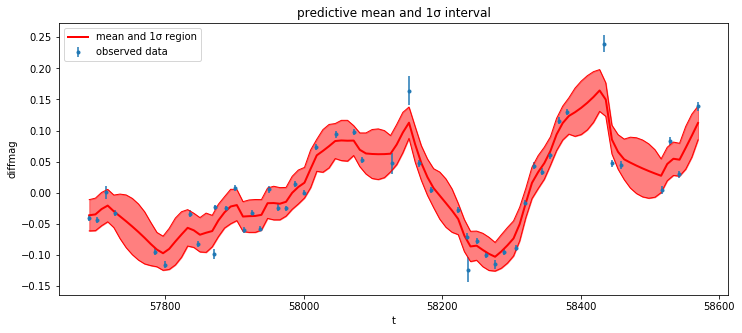

In [15]:
# predict
X_new=np.linspace(min(X),max(X),100)#new points we want to interpolate
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();

In [6]:
# add the GP conditional to the model, given the X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|██████████| 2000/2000 [01:24<00:00, 23.44it/s]


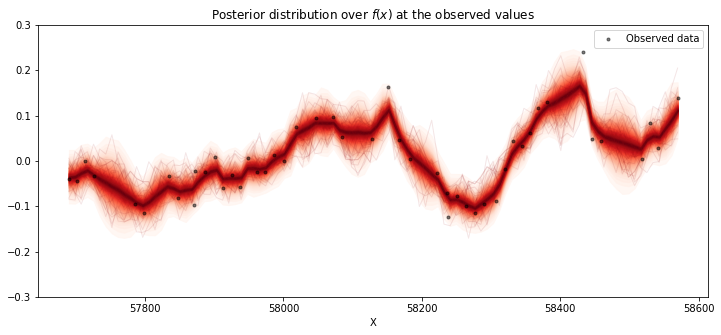

In [10]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
#plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-0.3,0.3]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

## This part of the script shows the trace from the NUTS sampling.

In [83]:
pm.traceplot(trace)
pm.summary(trace)
#pm.autocorrplot(trace, max_lag=20);

TypeError: Missing required input: f_pred

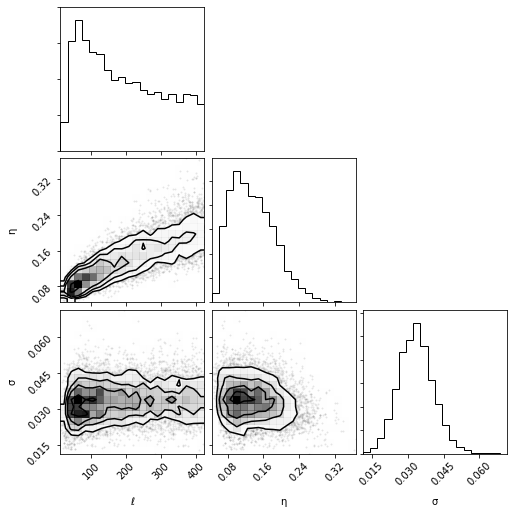

In [67]:
import corner
samples = pm.trace_to_dataframe(trace)
corner.corner(samples);

In [5]:
X_new=np.linspace(min(X),max(X),100)#new points we want to interpolate
# add the GP conditional to the model, given the X values
with model:
    f_pred = gp.conditional("f_pred", X_new)
    
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)
#This function will randomly draw 1000 samples of parameters from the trace. Then, for each sample,
#it will draw 100 random numbers from a normal distribution specified by the values of mu and std in that sample.

C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

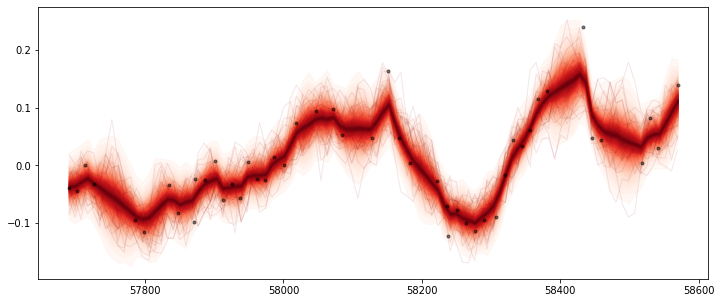

In [74]:
#Now, pred_samples contains 1000 generated data sets (containing 100 samples each),
#each using a different parameter setting from the posterior:

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

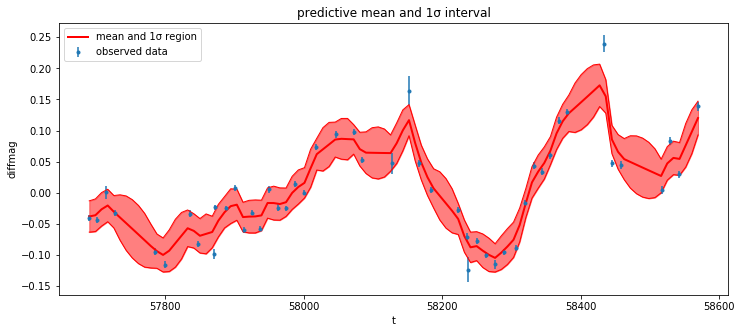

In [82]:
hpd = pm.stats.hpd(trace)
meanpoint=trace[-1]#hpd[0]

# predict
X_new=np.linspace(min(X),max(X),100)#new points we want to interpolate
mu, var = gp.predict(X_new, point=meanpoint, diag=True)
sd = np.sqrt(var)

#i=0
#mu=mu[i]
#sd=sd[i]

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();

In [79]:
hpd = pm.stats.hpd(trace)
print(len(trace))
print((np.median(trace['ℓ'])))
#pm.quantiles(trace)
print(trace[-1])
#print(pm.summary(trace))
#hpd[0]

2000
173.26213770859397
{'ℓ_interval__': -0.004898274676360059, 'η_interval__': -1.6102505574555115, 'σ_log__': -3.5070926613050566, 'ℓ': 212.73326711084076, 'η': 0.1665538298742107, 'σ': 0.02998396136927101}


## This part deals with the transfer function

In [34]:
import numpy as np
import scipy as sc
import scipy
import scipy.optimize as opt
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.random import randint
import math
from scipy.optimize import minimize as mini
from scipy.optimize import least_squares as ls
from scipy.optimize import leastsq
import gc
from multiprocessing import Process

In [35]:
#Define simple planck function
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

In [36]:
def transferDT(x,mu,sigma,A_T,wav,T):
    '''Defines the transfer function for the DT'''
    #sigma = float(sigma)
    #mu = float(mu)
    #x = x #float(x)
    #A_T = float(A_T)
    BB = planck(wav, T)
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = A_T/(x*sigma*np.sqrt(2*np.pi))
    return BB*front*np.exp(exp)

In [37]:
#might need to include a normalization here
#can you determine the index of the power law? Maybe by a fit in a filter?
def power(wav,wav_0,index):
    powr=(wav/wav_0)**(index)
    return powr

In [38]:
def transferAD(x,mu,sigma,A_T,wav,wav_0,index):
    '''Defines the transfer function for the AD'''
    #sigma = float(sigma)
    #mu = float(mu)
    #x = x #float(x)
    #A_T = float(A_T)
    #wav = float(wav)
    #wav_0 = float(wav_0)
    #index = float(index)
    powr = power(wav, wav_0, index)
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = (1.0-A_T)/(x*sigma*np.sqrt(2*np.pi))
    return powr*front*np.exp(exp)

In [39]:
def transfertot(x,mu_DT,mu_AD,sigma_DT,sigma_AD,A_T,T,wav,wav_0,index):
    transfer_DT = transferDT(x,mu_DT,sigma_DT,A_T,wav,T)
    transfer_AD = transferAD(x,mu_AD,sigma_AD,A_T,wav,wav_0,index)
    return transfer_DT + transfer_AD

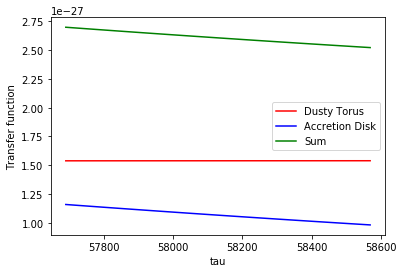

In [141]:
#define some data and parameters and plot the transfer functions 
#tau=np.linspace(0.01,4,100)
sigma_DT=1
sigma_AD=1
mu_DT=12
mu_AD=1
A_T=0.4
T=1700
wav=6200
wav_0=6200
index=1.0

resDT= 10**(5)*transferDT(X_new,mu_DT,sigma_DT,A_T,wav,T)
resAD= transferAD(X_new,mu_AD,sigma_AD,A_T,wav,wav_0,index)
ressum= resDT+resAD#transfertot(X_new,mu_DT,mu_AD,sigma_DT,sigma_AD,A_T,T,wav,wav_0,index)

plt.plot(X_new,resDT,'r',label="Dusty Torus")
plt.plot(X_new,resAD,'b',label="Accretion Disk")
plt.plot(X_new,ressum,'g',label="Sum")
plt.xlabel("tau")
plt.ylabel("Transfer function")
plt.legend()
plt.show()

## Now we will try to do a convolution model

In [41]:
with pm.Model() as convmodel: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma_DT=pm.Uniform('sigma_DT', lower=-7.0, upper=2.0)#The natural log of the width of the Dusty Torus lag
    sigma_AD=pm.Uniform('sigma_AD', lower=-7.0, upper=2.0)#The natural log of the width of the Accretion Disk lag
    mu_DT=pm.Uniform('mu_DT', lower=2.7, upper=4.0)#The natural log of the Dusty Torus lag
    mu_AD=pm.Uniform('mu_AD', lower=0.0, upper=2.3)#The natural log of the Accretion Disk lag
    A_T=pm.Uniform('A_T', lower=0.0, upper=1.0)#The thermal fraction of the observed flux
    T=pm.Uniform('T', lower=1300.0, upper=1700.0)#Temperature of the Dust Torus
    wav=pm.Uniform('wav', lower=0.0, upper=10000.0)#Wavelength
    wav_0=pm.Uniform('wav_0', lower=0.0, upper=10000.0)#Reference/normalization wavelength
    index=pm.Uniform('index', lower=0.0, upper=10.0)#Power law index
    sigma=pm.HalfNormal("sigma", sigma=np.sqrt(np.pi/(np.pi-2)))#
    # Define likelihood
    transfer=transfertot(X_new,mu_DT,mu_AD,sigma_DT,sigma_AD,A_T,T,wav,wav_0,index)
    likelihood = pm.Normal('y', mu=np.convolve(mu,transfer,'same'),
                        sigma=sigma, observed=y)

    # Inference!
    trace = pm.sample(3000) # draw 3000 posterior samples using NUTS sampling

ValueError: setting an array element with a sequence.

## Pay no mind to any of this stuff.

In [248]:
 import operator
# using map() + operator.sub 
# generate successive difference list 
res = list(map(operator.sub, X[1:], X[:-1]))
print(res)
print(np.mean(res))
print(max(X)-min(X))
print(yerr)
print(np.mean(y))

[array([11.885708]), array([12.050728]), array([12.965526]), array([58.278944]), array([13.999854]), array([36.008044]), array([11.87335]), array([23.162412]), array([1.96635]), array([14.987364]), array([13.960074]), array([11.967108]), array([11.861768]), array([12.063758]), array([11.975638]), array([12.964214]), array([11.967128]), array([12.953974]), array([13.25558]), array([17.929194]), array([28.975406]), array([24.841798]), array([12.005338]), array([43.297992]), array([23.93412]), array([15.038622]), array([16.996832]), array([38.991922]), array([14.062766]), array([0.9969965]), array([12.9659335]), array([12.964268]), array([13.060332]), array([12.876066]), array([17.941332]), array([12.939462]), array([11.993318]), array([11.965764]), array([11.966938]), array([12.282698]), array([11.958116]), array([52.825488]), array([11.935656]), array([13.00845]), array([59.288632]), array([11.987944]), array([12.00995]), array([28.035116])]
18.31716608333333
[879.223972]
[0.07904579 0.

In [11]:
#remember this only works where we have observations. 
res=y-mu
weights = np.ones_like(res)/float(len(res))
print(np.sum(weights))
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

muhist = 0
variance = 1
sigmahist = math.sqrt(variance)
xhist = np.linspace(muhist - 3*sigmahist, muhist + 3*sigmahist, 100)

#plt.plot(xhist, stats.norm.pdf(xhist, muhist, sigmahist))
plt.hist(res, weights=weights,density=False)
plt.show()

ValueError: operands could not be broadcast together with shapes (49,) (100,) 

In [8]:
from scipy import stats  
import numpy as np  
import matplotlib.pylab as plt

# create some normal random noisy data
ser = res

# plot normed histogram
plt.hist(ser, density=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(ser))

# lets try the normal distribution first
m, s = stats.norm.fit(ser) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it

plt.show() 

NameError: name 'res' is not defined

In [9]:
print(m)
print(s**2)

NameError: name 'm' is not defined

C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


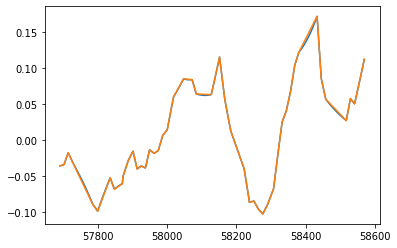

In [12]:
X_new1=np.linspace(min(X),max(X),1000)#new points we want to interpolate
X_new2=X
mu1, var1 = gp.predict(X_new1, point=mp, diag=True)
mu2, var2 = gp.predict(X_new2, point=mp, diag=True)

plt.plot(X_new1,mu1)
plt.plot(X_new2,mu2)